# **Credit Limit** Prediction Using Deep Neural Networks

## Authors
- **Kianoosh Vadaei**: Researcher
- **Melika Shirian**: Researcher

### Contact Information
- Kianoosh Vadaei: [email](mailto:kia.vadaei@gmail.com), [LinkedIn](https://www.linkedin.com/in/kianoosh-vadaei-0aa58611b/), [GitHub](https://github.com/kia-vadaei)
- Melika Shirian: [email](mel.shirian@gmail.com), [LinkedIn](https://www.linkedin.com/in/melika-shirian-b8477a254/), [GitHub](https://github.com/MelikaShirian12)


## Introduction
This notebook provides an analysis of **Credit Limit** Prediction. We will cover the following steps:
1. Data Loading
2. Data Preprocessing
3. Exploratory Data Analysis
4. Model Building
5. Model Evaluation
6. Conclusion

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Model Building](#Model-Building)
6. [Model Evaluation](#Model-Evaluation)
7. [Conclusion](#Conclusion)



In [312]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiplicativeLR
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from tqdm import *
import seaborn as sns

<a id='Data-Loading'></a>
## **Data Loading**
In this section, we will load the dataset and display the first few rows to understand its structure.


In [313]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 
# data_no_dup = data_no_dup.fillna(0)
# data_no_dup = pd.get_dummies(data_no_dup, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], drop_first=True, )


# data_no_dup.fillna(0, inplace=True)
data_no_dup

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,712110333,37.0,F,3,High School,NaN,Unknown,NaN,18.0,4.0,1,3,2179.0,0,0.725,2568,48,0.297,0.000,NaN
10134,712674183,53.0,M,2,College,NaN,$40K - $60K,Blue,33.0,3.0,3,1,4065.0,2180,0.321,1271,36,0.200,0.536,NaN
10135,718421808,56.0,F,2,Uneducated,Married,Unknown,Blue,43.0,6.0,3,2,3068.0,1765,0.853,4611,73,0.698,0.575,NaN
10136,809452383,37.0,F,2,Graduate,Married,Less than $40K,NaN,32.0,6.0,1,3,1438.3,0,0.707,4733,89,0.816,0.000,NaN


In [314]:
# plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
# plt.title("Boxplot of the sample after treating the outliers")
# plt.xlabel("Sample")
data_no_dup['Credit_Limit'].describe()

count    10132.000000
mean      8629.730201
std       9087.330401
min       1438.300000
25%       2555.000000
50%       4549.000000
75%      11063.250000
max      34516.000000
Name: Credit_Limit, dtype: float64

In [315]:
# plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
# plt.title("Boxplot of the sample after treating the outliers")
# plt.xlabel("Sample")
# a= data_no_dup[data_no_dup['Credit_Limit']>20000]
# a.shape

# upper=data_no_dup['Credit_Limit'].quantile(0.005)
# lower=data_no_dup['Credit_Limit'].quantile(0.91)
# print(upper, lower)


## **Handling Outliers:**

In [316]:
def detect_outliers_iqr(data_col, is_taeget=False):

    outliers = []
    data_sorted = sorted(data_col)
    q1 = np.percentile(data_sorted, 25)
    q3 = np.percentile(data_sorted, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    if is_taeget:
        lwr_bound = q1
        upr_bound = q3
        
    inbox_indcs = (data_sorted >= lwr_bound) & (data_sorted <= upr_bound)
    inbox_data = data_col[inbox_indcs]
    inbox_media = np.median(inbox_data)

    # print(lwr_bound, upr_bound)
    for d in data_sorted: 
        if (d<lwr_bound or d>upr_bound):
            index = data_col.loc[data_col == d].index
            for i in index:
                data_col[i] = inbox_media
            outliers.append(i)
    return outliers# Driver code

def fix_outliers(data, is_taeget=False):
    if is_taeget:
        outliers = detect_outliers_iqr(data, is_taeget=True)
        print(f"Fixed {len(outliers)} outliers in target column")
        return data
    else:
        for col in data.columns:
            if data[col].dtype != 'object':
                outliers = detect_outliers_iqr(data[col])
                print(f"Fixed {len(outliers)} outliers in {col} column")
        return data

## **Done Outliers:**

In [317]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [318]:
print(data_no_dup['Credit_Limit'].skew())
print(data_no_dup.shape)
sns.histplot(data=data_no_dup,x="Credit_Limit")
plt.show()

upper=data_no_dup['Credit_Limit'].quantile(0.25)
lower=data_no_dup['Credit_Limit'].quantile(0.75)

#print(upper,lower)

index=data_no_dup[(data_no_dup['Credit_Limit']>=lower)|(data_no_dup['Credit_Limit']<=upper)].index

data_no_dup.drop(index,inplace=True)
print(data_no_dup.shape)

data_no_dup['Credit_Limit'].describe()
print(data_no_dup['Credit_Limit'].skew())
plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

data_no_dup.shape


In [319]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [320]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)
X = fix_outliers(X)
# y = fix_outliers(y, is_taeget=True)



/home/kianoosh/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Fixed 0 outliers in 0 column
Fixed 19 outliers in 1 column
Fixed 0 outliers in 2 column
Fixed 578 outliers in 3 column
Fixed 0 outliers in 4 column
Fixed 331 outliers in 5 column
Fixed 629 outliers in 6 column
Fixed 0 outliers in 7 column
Fixed 396 outliers in 8 column
Fixed 897 outliers in 9 column
Fixed 2 outliers in 10 column
Fixed 395 outliers in 11 column
Fixed 0 outliers in 12 column
Fixed 0 outliers in 13 column
Fixed 0 outliers in 14 column
Fixed 1015 outliers in 15 column
Fixed 451 outliers in 16 column
Fixed 0 outliers in 17 column
Fixed 2014 outliers in 18 column
Fixed 516 outliers in 19 column
Fixed 1488 outliers in 20 column
Fixed 1519 outliers in 21 column
Fixed 595 outliers in 22 column
Fixed 0 outliers in 23 column
Fixed 0 outliers in 24 column
Fixed 621 outliers in 25 column
Fixed 727 outliers in 26 column
Fixed 1791 outliers in 27 column
Fixed 1402 outliers in 28 column
Fixed 1535 outliers in 29 column
Fixed 0 outliers in 30 column
Fixed 1115 outliers in 31 column
Fix

/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Fixed 2829 outliers in target column


/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = inbox_media
/tmp/ipykernel_13875/2504978936.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

count    10132.000000
mean      4905.060008
std       1708.675219
min       2555.000000
25%       4548.750000
50%       4549.000000
75%       4549.000000
max      11062.000000
Name: Credit_Limit, dtype: float64

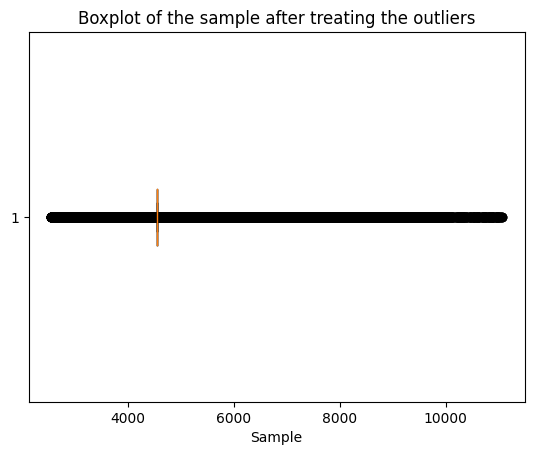

In [321]:
plt.boxplot(y, vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

y.describe()

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape

(6788, 25)

In [323]:
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_regression, k=X_train_pca.shape[1] - 8)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


In [324]:

X_train_fs, X_test_fs, fs = select_features(X_train_pca, y_train, X_test_pca)

Feature 0: 0.046040
Feature 1: 0.014790
Feature 2: 0.001879
Feature 3: 0.000000
Feature 4: 0.033950
Feature 5: 0.003886
Feature 6: 0.000000
Feature 7: 0.006134
Feature 8: 0.000000
Feature 9: 0.013042
Feature 10: 0.000000
Feature 11: 0.000000
Feature 12: 0.000000
Feature 13: 0.034916
Feature 14: 0.012899
Feature 15: 0.065094
Feature 16: 0.036309
Feature 17: 0.021071
Feature 18: 0.000000
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.000000
Feature 22: 0.001360
Feature 23: 0.000000
Feature 24: 0.000000
13


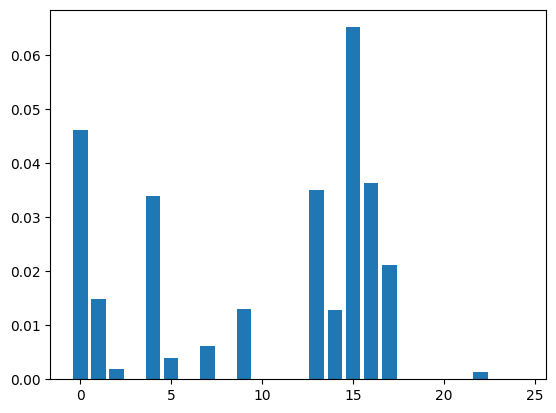

In [325]:
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [326]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 



In [327]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train = torch.from_numpy(X_train.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

X_test = torch.from_numpy(X_test.astype(np.float32))

_, n_features = X_train_fs.shape




In [328]:
X_train_fs  = X_train_fs.to(device)
y_train = y_train.to(device)
X_train = X_train.to(device)

X_test_fs  = X_test_fs.to(device)
y_test = y_test.to(device)

X_test = X_test.to(device)


In [329]:
class BankDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = (self.data[idx], self.targets[idx])
        return sample

In [330]:
dataset = BankDataset(X_train_fs, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [331]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.dropout(x)

        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        # out = self.sigmoid(out)
        return out

In [332]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model2, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(input_size, hidden_size)

        
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear3 = nn.Linear(int(hidden_size/2), 1)
        # self.linear4 = nn.Linear(12, 1)


        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.dropout(x)
        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        out = self.leaky_reLu(out)
        out = self.linear3(out)
        # out = self.leaky_reLu(out)
        # out = self.linear4(out)
        # out = self.sigmoid(out)
        return out

In [333]:
model = Model2(n_features , 16)
model = model.to(device)

n_features

17

In [334]:
num_epochs = 300000
learning_rate = 0.001
list_of_losses = []
list_of_losses_test = []
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lmbda = lambda epoch: 0.95

scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
lambda_reg = 0.01
loss = 0



for epoch in range(num_epochs):
    # Forward pass and loss
    # model.zero_grad()
    y_pred = model(X_train_fs)
    loss = criterion(y_pred, y_train)

    # TODO Validation
    # TODO Bath
    # TODO 2 for

    # # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    l2_reg = l2_reg.to(device)

    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # zero grad before new step

    if (epoch+1) % 1000 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f} || "
              f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.7f}")
        list_of_losses.append(loss.item())
        list_of_losses_test.append(criterion(model(X_test_fs), y_test).item())
    if (epoch+1) % 5000 == 0 and epoch > 5000:
        scheduler.step()
    



epoch: 1000, loss = 16793248.0000 || lr: 0.0010000
epoch: 2000, loss = 3578860.5000 || lr: 0.0010000
epoch: 3000, loss = 3029057.7500 || lr: 0.0010000
epoch: 4000, loss = 2839660.5000 || lr: 0.0010000
epoch: 5000, loss = 2715947.2500 || lr: 0.0010000
epoch: 6000, loss = 2628677.7500 || lr: 0.0010000
epoch: 7000, loss = 2530348.2500 || lr: 0.0010000
epoch: 8000, loss = 2402133.2500 || lr: 0.0010000
epoch: 9000, loss = 2392452.7500 || lr: 0.0010000
epoch: 10000, loss = 2333055.7500 || lr: 0.0010000
epoch: 11000, loss = 2327207.2500 || lr: 0.0009500
epoch: 12000, loss = 2308548.7500 || lr: 0.0009500
epoch: 13000, loss = 2348095.5000 || lr: 0.0009500
epoch: 14000, loss = 2316953.7500 || lr: 0.0009500
epoch: 15000, loss = 2332904.7500 || lr: 0.0009500


KeyboardInterrupt: 

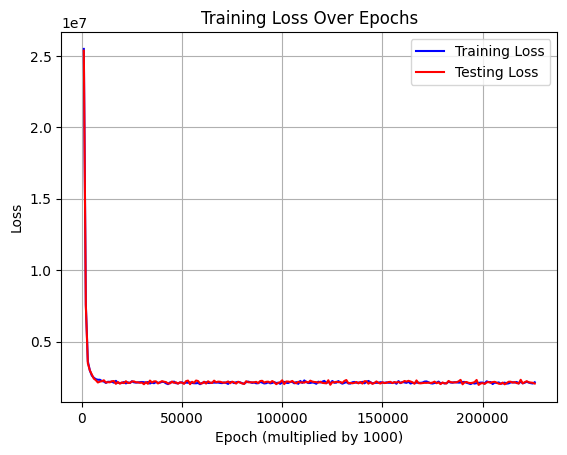

In [ ]:
epochs = [epoch * 1000 for epoch in range(1, len(list_of_losses) + 1)]

# Plot the losses
plt.plot(epochs, list_of_losses, linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, list_of_losses_test, linestyle='-', color='r', label='Testing Loss')

# Add title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch (multiplied by 1000)')
plt.ylabel('Loss')

# Add grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    y_predicted = model(X_test_fs)
    # y_predicted = np.array(y_predicted)
     
    MSE = mean_squared_error(y_predicted.cpu(), y_test.cpu())
MSE

3142348.8